# Técnicas de Regressão em Letras Persas

## Pré-processamento

In [1]:
# Instalação de dependências.
!pip install opencv-python numpy matplotlib scikit-learn

import os, random, sys, time
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

O código abaixo percorre um diretório e seus subdiretórios em busca de arquivos com extensão '.jpg'. Para cada arquivo encontrado, ele extrai a classe da imagem a partir do nome do diretório onde está localizado o arquivo e adiciona essa classe a uma lista enquanto armazena o caminho completo do arquivo em outra lista.

In [2]:
directory = '../datasets/plf50'
images, classes = [], []

for root, dirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith('.jpg'):
            file_path = os.path.join(root, filename)

            # Ler a classe da imagem retirando informação do nome do arquivo.
            splitted_string = file_path.split('/')
            image_class = splitted_string[-2]
            classes.append(image_class)

            images.append(file_path)

Funções fornecidas no exemplo.

In [3]:
def save_img(path, img):
    files = path.split("\\")
    os.makedirs(files[0]+"2\\"+files[1], exist_ok=True) #cria as pastas onde a imagem cópia ficará
    cv2.imwrite(files[0]+"2\\"+files[1]+"\\"+files[2], 255*img, [cv2.IMWRITE_JPEG_QUALITY, 100]) #escreve a imagem no diretorio da
                                                                                                 #sua classe com qualidade jpeg 100
    return                                                                                       #e escala de 0 a 255

def read_img_to_gray_scale(path, size_x=16, size_y=16): #lê a imagem na escala cinza, a redimensiona e normaliza os valores para [0, 1]
    return cv2.resize(cv2.imread(path, 0)/255.0, (size_x, size_y))

def read_img_to_gray_scale_vector(path, size_x=16, size_y=16): #identico a readImgToGrayScale, mas transforma o resultado em vetor unidimensional
    return cv2.resize(cv2.imread(path, 0)/255.0, (size_x, size_y)).flatten()

def gray_scale_vector_to_img(vector, size_x=16, size_y=16): #retorna um vetor unidimensional para forma de matriz original (size_x, size_y)
    return np.reshape(vector, (size_x, size_y))

def plot_img(img): #visualiza a imagem
    plt.imshow(img, cmap="gray")
    plt.show()
    return

O código a seguir cria uma lista `x` contendo vetores unidimensionais representando as imagens após processamento para escala de cinza. Em seguida, as classes das imagens são armazenadas em uma lista `y`. Posteriormente, ele divide os dados em conjuntos de treinamento (`x_train`, `y_train`) e teste (`x_test`, `y_test`) usando a função `train_test_split` da biblioteca `scikit-learn`, com 30% dos dados destinados ao conjunto de teste.

In [4]:
x = []

# Juntar todos os vetores unidimensionais das imagens na lista X.
for image in images:
    x.append(read_img_to_gray_scale_vector(image))

# As classes das imagens, mas em uma lista com nome Y.
y = classes

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

A distância euclidiana entre dois vetores no mesmo espaço vetorial é definida por:

$$ D(\mathbf{p}, \mathbf{q}) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2} $$


In [5]:
# Função implementada seguindo a definição descrita em:
# https://en.wikipedia.org/wiki/Euclidean_distance
def euclidean_distance(p, q):
    return np.sqrt(np.sum((np.array(p) - np.array(q)) ** 2))

Definir função do algoritmo K-Nearest Neighbor (KNN) para K=1.

In [6]:
# Função implementada seguindo a definição descrita em:
# https://www.ibm.com/topics/knn#:~:text=The%20k%2Dnearest%20neighbors%20(KNN)%20algorithm%20is%20a%20non,used%20in%20machine%20learning%20today.
def knn(x_train, y_train, test_data, distance_function):
    min_distance = float('inf')
    nearest_neighbor_class = None

    for index, x in enumerate(x_train):
        distance = distance_function(test_data, x)
        if distance < min_distance:
            min_distance = distance
            nearest_neighbor_class = y_train[index]

    return nearest_neighbor_class

## Aplicação de Técnicas

No bloco de código abaixo, é realizada a centralização dos dados de treinamento e teste utilizando o vetor de média que também será extraído.

In [7]:
# Calcular vetor de média.
mean_vector = np.mean(x_train, axis=0)

# Centralizar dados de treinamento.
x_train_center = x_train - mean_vector

# Centralizar dados de teste. Repare que é utilizado o vetor de média de treinamento.
x_test_center = x_test - mean_vector

Abaixo será calculada a decomposição SVD da matriz de dados de treinamento `x_train_center`. A função `np.linealg.svd` retornar 3 matrizes:
- `U` é uma matriz unitária (n_samples, n_samples).
- `S` é um vetor com os valores singulares (n_samples,).
- `Vt` é a matriz unitária transposta (n_features, n_features).

In [8]:
U, S, Vt = np.linalg.svd(x_train_center, full_matrices=False)

S_diagonal = np.diag(S)

Apresentar gráfico número de valores singulares x variabilidade acumulada.

In [9]:
# Calcular variabilidade para cada valor singular.
explained_variability = (S**2) / np.sum(S**2)

# Calcular variabilidade acumulada.
cumulative_variability = np.cumsum(explained_variability)

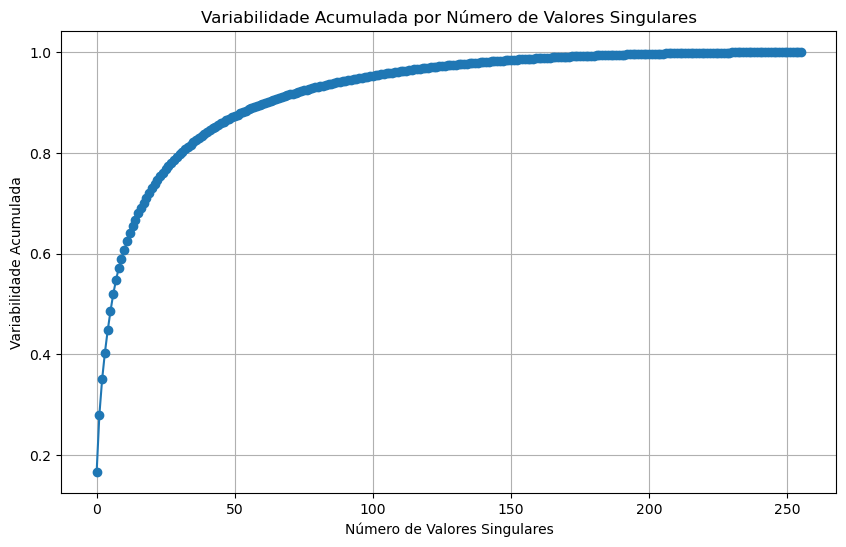

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variability, marker='o')
plt.xlabel('Número de Valores Singulares')
plt.ylabel('Variabilidade Acumulada')
plt.title('Variabilidade Acumulada por Número de Valores Singulares')
plt.grid(True)
plt.show()

In [11]:
# Escolher a variabilidade desejada.
desired_variability = 0.95

# Encontrar o número de componentes principais r que explicam a variabilidade desejada.
r = np.argmax(cumulative_variability >= desired_variability) + 1

print(f"Número de componentes principais para {desired_variability*100}% de variabilidade: {r}")

# Selecionar os r primeiros componentes de Vt (primeiras r linhas de Vt).
Vt_reduced = Vt[:r, :]

p_train = x_train_center @ Vt_reduced.T
p_test = x_test_center @ Vt_reduced.T

print("Matrizes de componentes principais calculadas.")
print("p_train.shape:", p_train.shape)
print("p_test.shape:", p_test.shape)

Número de componentes principais para 95.0% de variabilidade: 98
Matrizes de componentes principais calculadas.
p_train.shape: (403, 98)
p_test.shape: (173, 98)


## Realizar Predição

In [12]:
# Iterar entre os elementos do conjunto de teste (x_test) e executar o algoritmo.
avg_time, accuracy = 0, 0

for index, p in enumerate(p_test):
    start = time.time() # Iniciar cronômetro.
    result = knn(p_train, y_train, p, euclidean_distance) # Realizar teste e extrair resultado.
    end = time.time() # Parar cronômetro.

    total_time = end - start # Medir tempo decorrido.
    avg_time += total_time # Armazenar tempo decorrido na variável de tempo médio.
    
    # Testar acurácia do teste.
    if result == y_test[index]:
        accuracy += 1

print('tempo médio de execução: ', round(avg_time / len(p_test), 5), 'segundos')
print('acurácia dos testes: ', round(accuracy / len(p_test), 2))

tempo médio de execução:  0.00131 segundos
acurácia dos testes:  0.82


Refazer os testes com 5 valores de `r` diferentes. O código abaixo calcula os valores de `r` a serem utilizados.

In [13]:
desired_variabilities = [0.75, 0.8, 0.85, 0.9, 0.95]
r_values = []

for v in desired_variabilities:
    r = np.argmax(cumulative_variability >= v) + 1
    r_values.append(r)

r_values

[24, 32, 44, 63, 98]

In [14]:
avg_times, accuracies = [], []

for r in r_values:
    Vt_reduced = Vt[:r, :]
    
    p_train = x_train_center @ Vt_reduced.T
    p_test = x_test_center @ Vt_reduced.T

    avg_time, accuracy = 0, 0

    for index, p in enumerate(p_test):
        start = time.time() # Iniciar cronômetro.
        result = knn(p_train, y_train, p, euclidean_distance) # Realizar teste e extrair resultado.
        end = time.time() # Parar cronômetro.
    
        total_time = end - start # Medir tempo decorrido.
        avg_time += total_time # Armazenar tempo decorrido na variável de tempo médio.
        
        # Testar acurácia do teste.
        if result == y_test[index]:
            accuracy += 1

    avg_time = round(avg_time / len(p_test), 5)
    accuracy = round(accuracy / len(p_test), 2)

    print('valor de r:', r)
    print('tempo médio de execução: ', avg_time, 'segundos')
    print('acurácia dos testes: ', accuracy)
    print('------------------------------')

    avg_times.append(avg_time)
    accuracies.append(accuracy)

valor de r: 24
tempo médio de execução:  0.00141 segundos
acurácia dos testes:  0.84
------------------------------
valor de r: 32
tempo médio de execução:  0.00133 segundos
acurácia dos testes:  0.85
------------------------------
valor de r: 44
tempo médio de execução:  0.00136 segundos
acurácia dos testes:  0.84
------------------------------
valor de r: 63
tempo médio de execução:  0.00134 segundos
acurácia dos testes:  0.83
------------------------------
valor de r: 98
tempo médio de execução:  0.00147 segundos
acurácia dos testes:  0.82
------------------------------


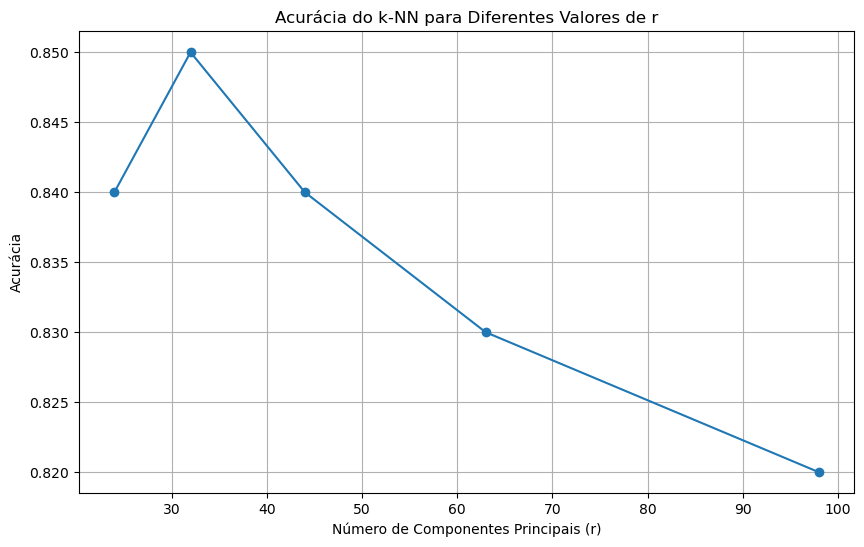

In [15]:
# Plotar o gráfico de r por acurácia
plt.figure(figsize=(10, 6))
plt.plot(r_values, accuracies, marker='o')
plt.xlabel('Número de Componentes Principais (r)')
plt.ylabel('Acurácia')
plt.title('Acurácia do k-NN para Diferentes Valores de r')
plt.grid(True)
plt.show()